In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import tangram as tg

# custom module
import resolve as rs
import seaborn as sns

/home/kleiss/miniconda3/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hum = rs.read_flat_data_to_andata( 'single_nuc_data/sparse_matrix/matrix.mtx',
#                                 'single_nuc_data/sparse_matrix/barcodes.tsv',
#                                 'single_nuc_data/sparse_matrix/features.tsv',
#                                 'single_nuc_data/metadata.csv',
#                                 obsm={'umap': 'single_nuc_data/dimred_umap2d.csv',
#                                       'liger': 'single_nuc_data/dimred_liger.csv'} )

# hum.var.index.name = 'gene_id'

# hum.write_h5ad('single_nuc_data/hum_andata.h5')

In [3]:
hum = sc.read_h5ad('single_nuc_data/hum_andata.h5')
hum

AnnData object with n_obs × n_vars = 180956 × 27715
    obs: 'orig_cluster', 'orig_sub_cluster', 'mou_transfer', 'pred_score', 'mou_cluster', 'no_cells', 'split.', 'subtype', 'dev_state', 'cell_type', 'origin', 'precisest_label', 'notes', 'UMAP1', 'UMAP2', 'batch', 'species', 'Organism', 'Tissue', 'Stage', 'HUM.corr..stage', 'TissueID', 'batch_date', 'Capture.System', 'stage.ord', 'validation', 'new_subtype', 'new_dev_state', 'new_cell_type', 'new_origin', 'new_precisest_label', 'old_subtype', 'old_dev_state', 'old_cell_type', 'old_origin', 'old_precisest_label'
    var: 'gene_symbol'
    obsm: 'liger', 'umap'

In [4]:
sp = sc.read_mtx('results/sparse_counts/matrix.mtx').T
sp

AnnData object with n_obs × n_vars = 130285 × 100

In [5]:
obs = pd.read_csv('results/sparse_counts/barcodes.tsv',
                  header=None,
                  index_col=None)
obs.columns = ['cell_id']
obs = obs.set_index('cell_id')

obs_metadata = pd.read_csv('results/metadata.csv')
obs_metadata = obs_metadata.reset_index().set_index('cell_id')

var = pd.read_csv('results/sparse_counts/features.tsv',
                header=None,
                index_col=None)
var.columns = ['gene_name']
var = var.set_index('gene_name')

sp.var = var
sp.obs = obs

sp.obs = sp.obs.join(obs_metadata)

sp

AnnData object with n_obs × n_vars = 130285 × 100
    obs: 'index', 'cell', 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence'

[2022-09-08 09:41:00,230] - _init_num_threads: Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2022-09-08 09:41:00,231] - _init_num_threads: NumExpr defaulting to 8 threads.


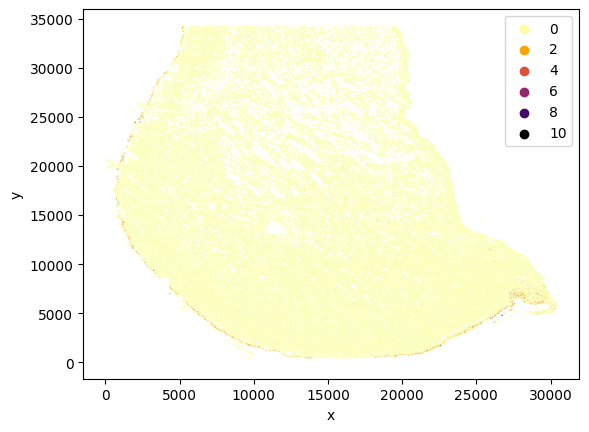

In [6]:
sns.scatterplot(
    x = sp.obs['x'],
    y = sp.obs['y'],
    hue = sp.X[:,np.flatnonzero(sp.var_names == 'ATOH1')].toarray().flatten(),
    s = 0.5,
    palette = 'inferno_r'
);

In [7]:
gns_all = pd.read_csv('/home/kleiss/ws/cerebellum_analysis/data/metadata/all_genes_meta.csv')

gns_all = gns_all.loc[ gns_all['species'] == 'HUM', : ]

gns_trans = gns_all[['gene_id', 'gene_name']].drop_duplicates()

In [8]:
tmp = hum.var.copy()

tmp.index.name = 'gene_id'
tmp = tmp.join(gns_trans.set_index('gene_id'))

In [9]:
gene_translate = {tmp.index.values[i]: tmp['gene_name'].values[i] for i in range(0, tmp.shape[0])}

In [10]:
translated_ids = hum.var.reset_index()['gene_id'].map(lambda x: gene_translate[x])
translated_ids.index = hum.var.index.values

In [11]:
hum.var['gene_name'] = translated_ids

In [12]:
hum.var = hum.var.reset_index().set_index('gene_name')

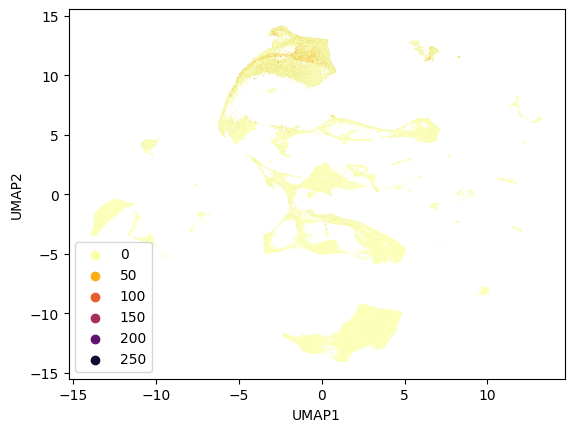

In [13]:
sns.scatterplot(
    x = hum.obs['UMAP1'],
    y = hum.obs['UMAP2'],
    hue = hum.X[:,np.flatnonzero(hum.var_names == 'FOXP2')].toarray().flatten(),
    s = 0.5,
    palette = 'inferno_r'
);

Filtering for the correct stage:

In [14]:
use_stage = '11 wpc'
hum = hum[ hum.obs['Stage'] == use_stage, :]

In [15]:
sc.pp.filter_genes(hum, min_cells = 20)
hum.shape

(13445, 21947)

In [16]:
hum.raw = hum.copy()
sp.raw = andata.copy()

NameError: name 'andata' is not defined

In [17]:
sc.pp.normalize_total(hum)
sc.pp.normalize_total(sp)

In [19]:
tg.pp_adatas(hum, sp)

[2022-09-08 09:42:45,367] - pp_adatas: 93 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
[2022-09-08 09:42:45,372] - pp_adatas: 93 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
[2022-09-08 09:42:45,375] - pp_adatas: uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
[2022-09-08 09:42:45,381] - pp_adatas: rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [20]:
ad_map = tg.map_cells_to_space(hum, sp)

[2022-09-08 09:42:45,390] - map_cells_to_space: Allocate tensors for mapping.
[2022-09-08 09:42:45,776] - map_cells_to_space: Begin training with 93 genes and rna_count_based density_prior in cells mode...
[2022-09-08 09:44:33,324] - train: Printing scores every 100 epochs.


Score: 0.232, KL reg: 0.000
Score: 0.873, KL reg: 0.014
Score: 0.913, KL reg: 0.007
Score: 0.923, KL reg: 0.006
Score: 0.927, KL reg: 0.006
Score: 0.930, KL reg: 0.006
Score: 0.932, KL reg: 0.005
Score: 0.933, KL reg: 0.005
Score: 0.934, KL reg: 0.005
Score: 0.935, KL reg: 0.005


[2022-09-08 14:03:32,379] - map_cells_to_space: Saving results..


In [21]:
ad_map.write_h5ad('results/single_cell_map.h5')

In [22]:
tg.project_cell_annotations(ad_map, sp, annotation='dev_state')

[2022-09-08 14:04:00,713] - project_cell_annotations: spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [52]:
sp_proj_genes = tg.project_genes(ad_map, hum)

In [62]:
sp_proj_genes.write_h5ad('results/spacial_with_projected_genes.h5')

In [63]:
np.save('results/spacial_with_projected_genes.npy', sp_proj_genes.X)

index    cell             x             y  cluster  n_transcripts  \
cell_id                                                                       
X1            0       1   9587.213333    213.240000        4             75   
X2            1       2   9615.985915    323.760563        4             71   
X3            2       3   9935.878788     47.484848        4             66   
X4            3       4   9651.659091    393.454545        4             44   
X5            4       5   9586.272727    434.045455        4             22   
...         ...     ...           ...           ...      ...            ...   
X138379  130280  138379  24592.285714  13056.428571        3              7   
X138383  130281  138383   6181.400000  33640.000000        2             10   
X138389  130282  138389  21625.000000  16329.800000        3              5   
X138391  130283  138391   8862.000000   3381.428571        4              7   
X138418  130284  138418  11849.833333  11326.833333        3              6   

         density  elongation    area  avg_confidence  uniform_density  \
cell_id                                                                 
X1       0.02149       3.510  3490.0          0.9932         0.000008   
X2       0.02616       5.721  2714.0          0.9954         0.000008   
X3       0.03556       1.462  1856.0          0.9972         0.000008   
X4       0.01609       2.196  2734.0          0.9625         0.000008   
X5       0.02449      12.370   898.5          0.9989         0.000008   
...          ...         ...     ...             ...              ...   
X138379  0.04811       3.471   145.5          0.9978         0.000008   
X138383  0.01487      12.100   672.5          0.9979         0.000008   
X138389  0.07407       4.033    67.5          0.9935         0.000008   
X138391  0.16670       3.516    42.0          1.0000         0.000008   
X138418  0.11430       5.092    52.5          1.0000         0.000008   

         rna_count_based_density  
cell_id                           
X1                      0.000008  
X2                      0.000008  
X3                      0.000008  
X4                      0.000008  
X5                      0.000008  
...                          ...  
X138379                 0.000008  
X138383                 0.000008  
X138389                 0.000008  
X138391                 0.000008  
X138418                 0.000008  

[130285 rows x 12 columns]

In [64]:
sp_proj_genes.obs.to_csv('results/spacial_with_projected_genes_obs.csv')
sp_proj_genes.var.to_csv('results/spacial_with_projected_genes_var.csv')

In [23]:
sp.obsm['tangram_ct_pred'].columns

Index([            'GABA_MB',    'Purkinje_defined',                   nan,
          'glut_DN_maturing',          'progenitor',     'GABA_DN_defined',
       'interneuron_defined',                 'GCP',           'GC_diff_1',
                 'GC_diff_2',     'VZ_neuroblast_2',              'immune',
           'glut_DN_defined',     'VZ_neuroblast_3',        'parabrachial',
          'NTZ_neuroblast_3',       'Purkinje_diff',    'interneuron_diff',
          'oligo_progenitor',         'UBC_defined',     'VZ_neuroblast_1',
                  'UBC_diff',           'erythroid',    'NTZ_neuroblast_2',
               'isth_N_diff',      'isth_N_defined',           'glioblast',
             'noradrenergic',            'GCP/UBCP',        'mural/endoth'],
      dtype='object')

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

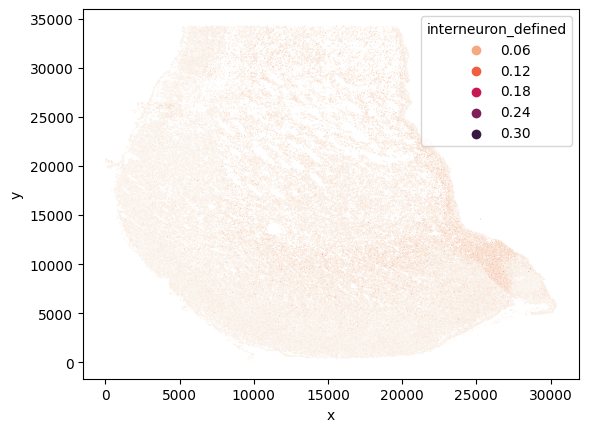

In [31]:
sns.scatterplot(
    x = sp.obs['x'],
    y = sp.obs['y'],
    hue = sp.obsm['tangram_ct_pred']['interneuron_defined'],
    s = 0.25,
    palette = 'rocket_r'
);

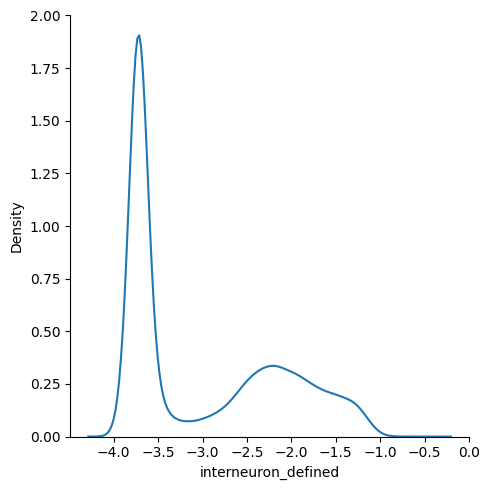

In [35]:
sns.displot(np.log10(sp.obsm['tangram_ct_pred']['interneuron_defined']), kind='kde');

In [46]:
sp.obs['pred_dev_state'] = sp.obsm['tangram_ct_pred'].apply(lambda x: np.array(list(x.index))[x == x.max()][0], axis=1)

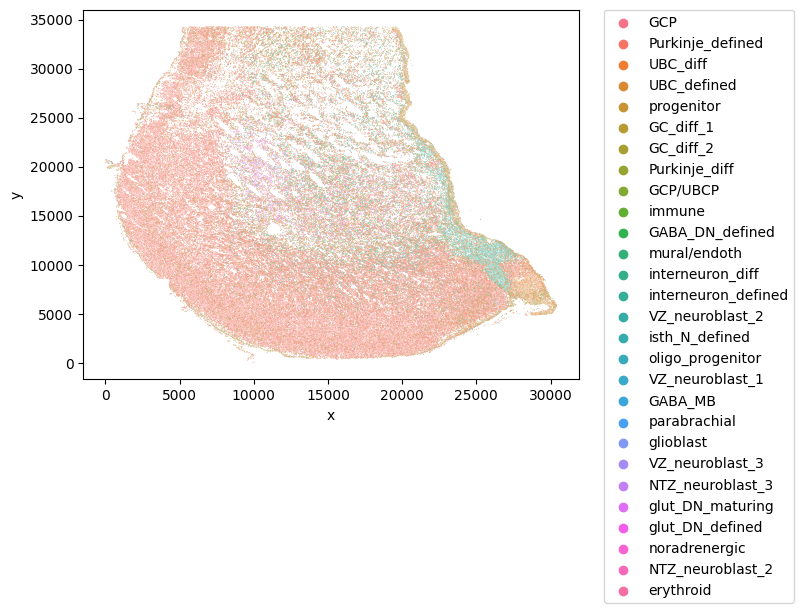

In [50]:
sns.scatterplot(
    x = sp.obs['x'],
    y = sp.obs['y'],
    hue = sp.obs['pred_dev_state'],
    s = 0.25
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Saving the results

In [65]:
sp.obsm['tangram_ct_pred'].to_csv('results/tangram_dev_state_prob.csv')

In [66]:
sp.obs.to_csv('results/tangram_dev_state_probMax.csv')